In [1]:
from pathlib import Path

ROOT = Path(globals()['__vsc_ipynb_file__']).parent.parent
print(ROOT)

import sys
sys.path.append(str(ROOT))

/Users/gabrieleagliardi/Documents/GitHub/Client-Vanguard-Optimization


In [2]:
from qiskit import qpy
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [7]:
from src.step_1 import build_ansatz, get_backend

In [5]:
num_vars = 109
instance = 'vanguard/internal/default'

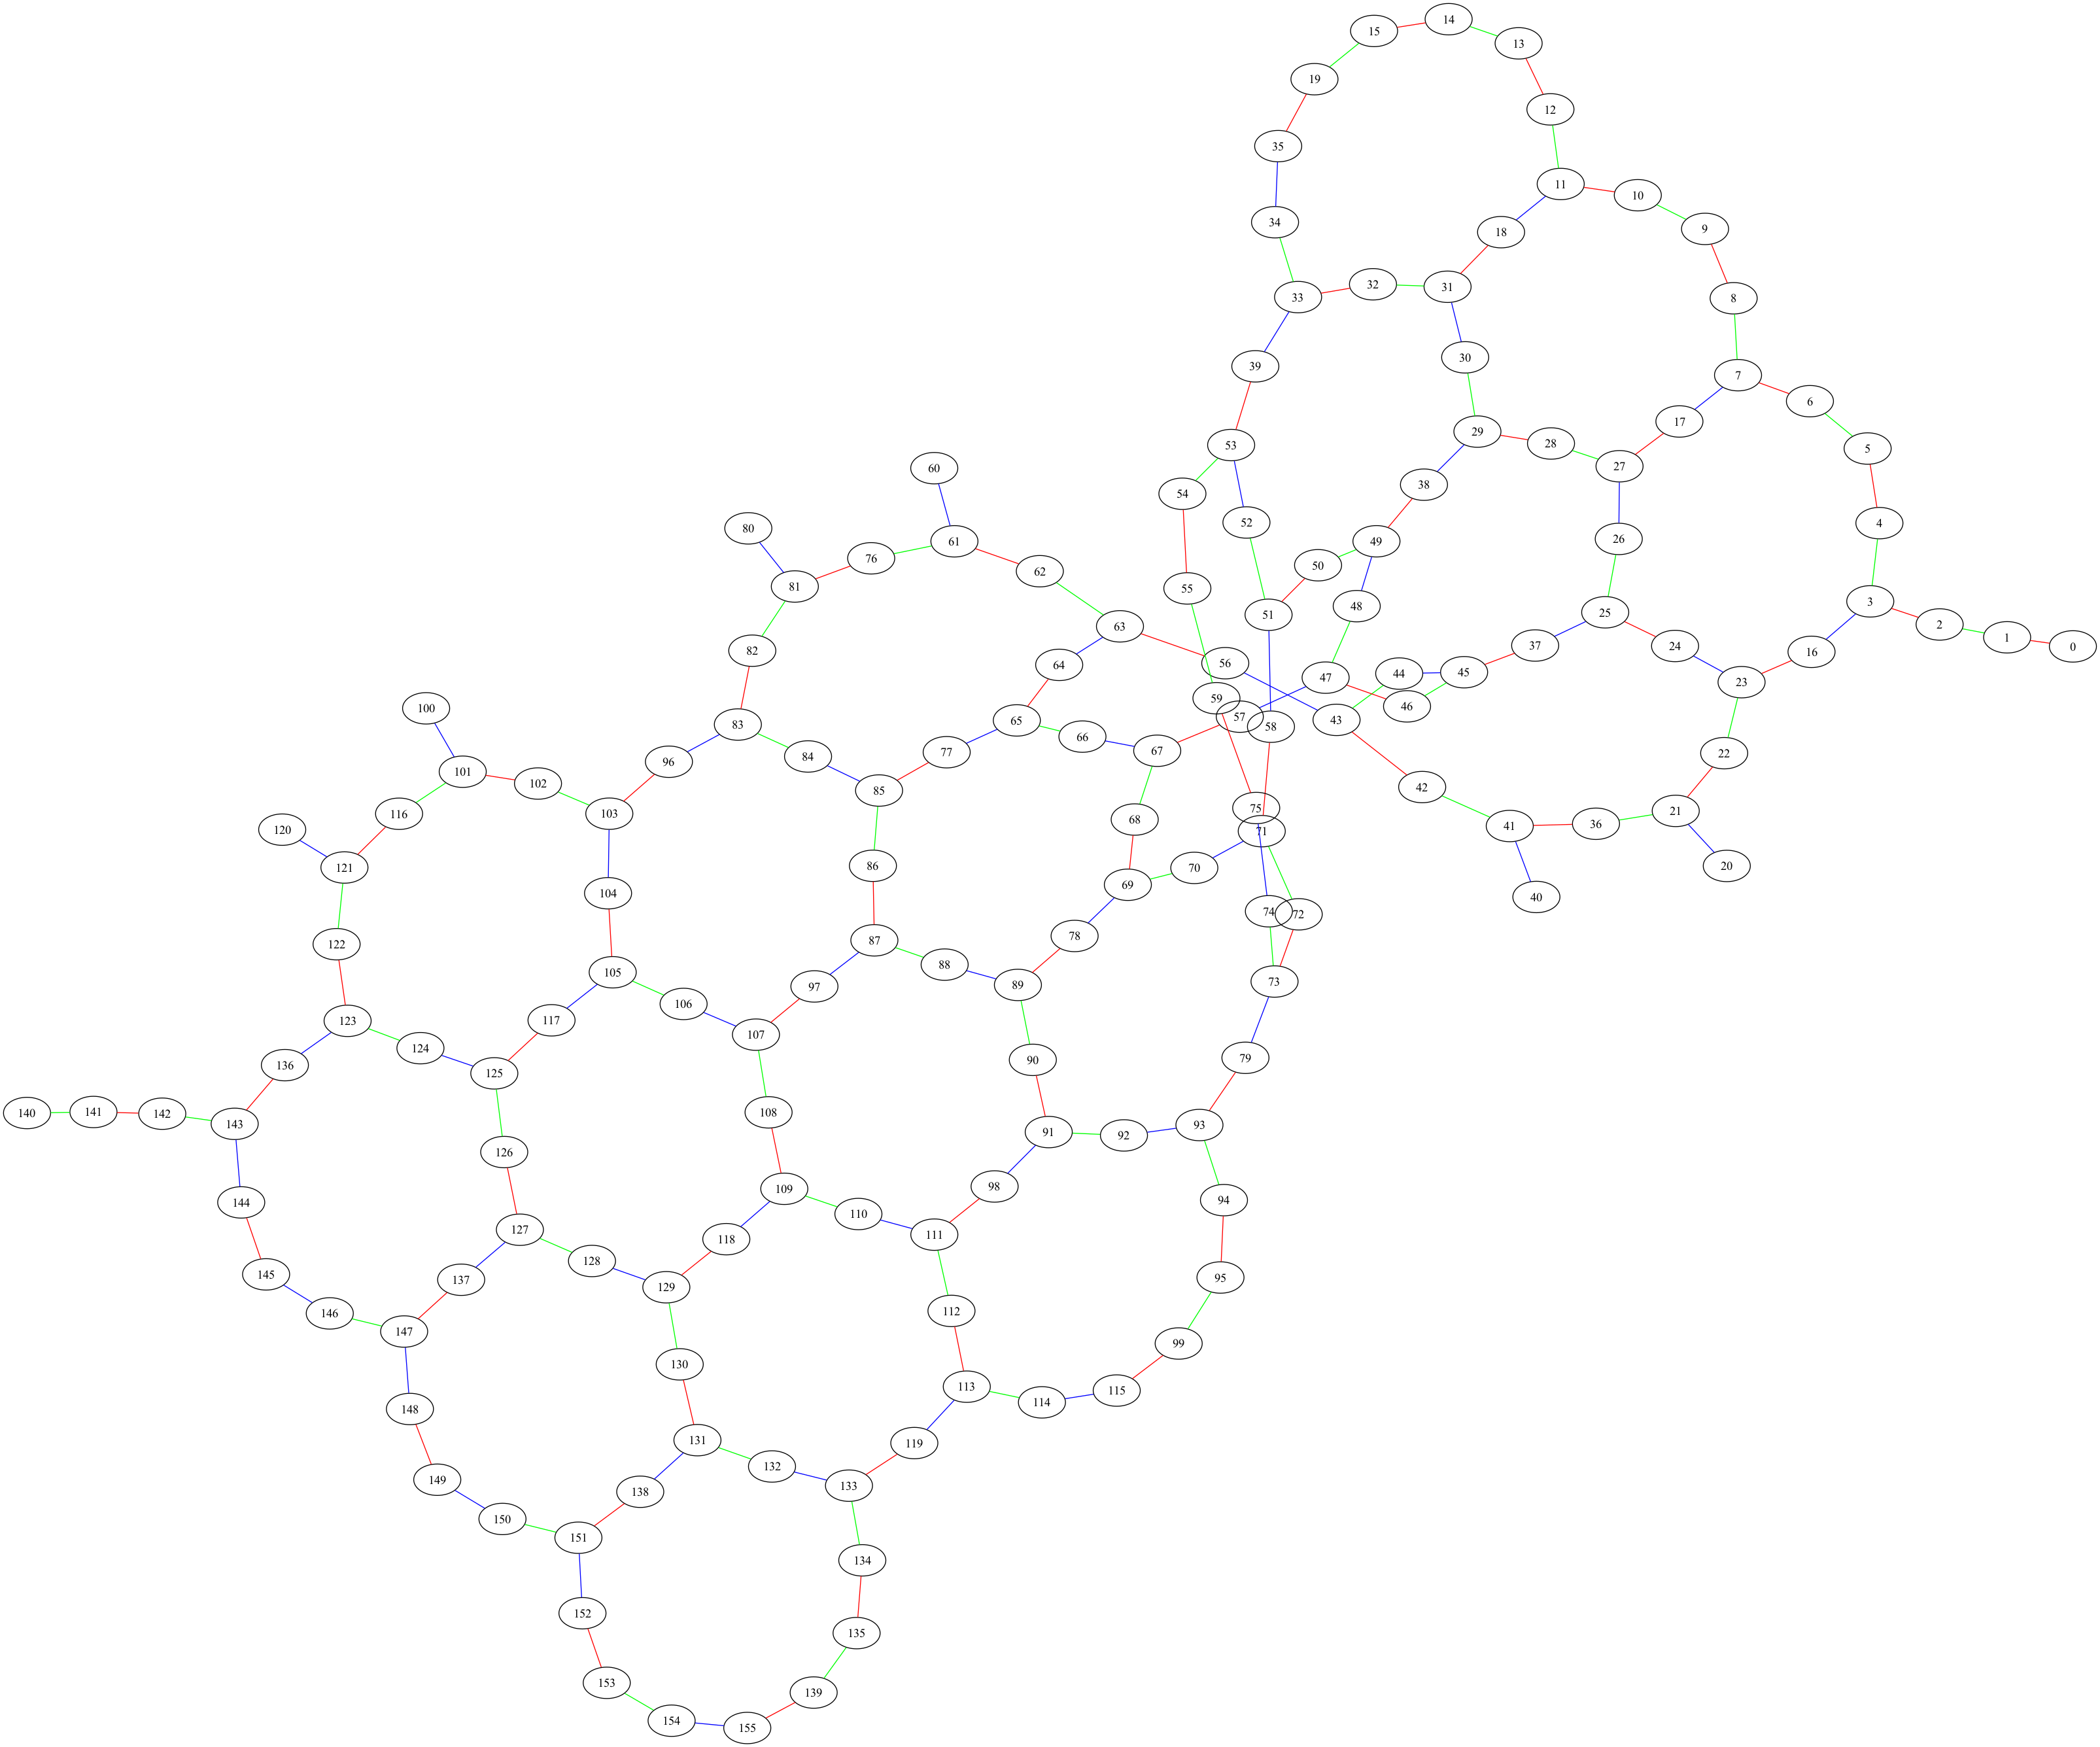

In [5]:
backend = get_backend('ibm_marrakesh', instance, num_vars)

from qiskit_addon_utils.coloring import auto_color_edges

coloring: dict = auto_color_edges([(i,j) for i,j in backend.coupling_map if i<j])

from rustworkx import PyDiGraph, PyGraph
topology = PyGraph()
topology.extend_from_weighted_edge_list(
    [(source, target, color) for ((source, target), color) in coloring.items()]
)

def color_edge(edge):
    color_dict = {0: "red", 1: "green", 2: "blue", 3:'yellow', 4:'purple', 5:'black'}
    return {"color": color_dict[edge]}

from rustworkx.visualization import graphviz_draw
graphviz_draw(topology, edge_attr_fn=color_edge, method="neato")

In [ ]:
ansatz_, initial_layout = build_ansatz('TwoLocal', {'entanglement': 'color', 'reps':1}, num_vars, backend)
print('2q-depth:', ansatz_.decompose().depth(lambda x:x.operation.num_qubits==2))
ansatz_.decompose().draw('mpl', fold=-1)

2q-depth: 3


In [7]:
isa_circuit = generate_preset_pass_manager(target=backend.target, initial_layout=initial_layout, optimization_level=3).run(ansatz)
print('2q-depth:', isa_circuit.depth(lambda x:x.operation.num_qubits==2))
isa_circuit.draw('mpl', fold=-1)

2q-depth: 3


In [9]:
outputs = []

for device in ['ibm_marrakesh', 'ibm_kyiv']:
    backend = get_backend(device, instance, num_vars)
    for ansatz in ['TwoLocal', 'bfcd']:
        for reps in [1,2,3]:
            ansatz_params = {'entanglement': ('color' if backend.coupling_map.is_symmetric else 'di-color'), 'reps':reps}
            ansatz_, initial_layout = build_ansatz(ansatz, ansatz_params, num_vars, backend)
            for use_init_layout in [True, False]:

                # step_2 CIRCUIT OPTIMIZATION
                for trial in range(10):
                    print(device, ansatz, reps, trial)
                    out_path = f'{ROOT}/data/transpilation/{ansatz_params["entanglement"]}/{num_vars}_pm_{device}_{ansatz}_{reps}_{use_init_layout}_{trial}.qpy'
                    if Path(out_path).is_file():
                        with open(out_path, 'br') as f:
                            isa_ansatz = qpy.load(f)[0]
                    else:
                        isa_ansatz = generate_preset_pass_manager(target=backend.target, optimization_level=3, initial_layout=initial_layout if use_init_layout else None).run(ansatz_)
                        with open(out_path, 'bw') as f:
                            qpy.dump(isa_ansatz, f)
                    outputs.append({'ansatz': ansatz, 'reps': reps, 'device': device, 'trial': trial, 'use_init_layout': use_init_layout,
                                    'depth': isa_ansatz.depth(),
                                    '2q-depth': isa_ansatz.depth(lambda x:x.operation.num_qubits==2),
                                    'count_ops': isa_ansatz.count_ops(),
                                    })

ibm_marrakesh TwoLocal 1 0
ibm_marrakesh TwoLocal 1 1
ibm_marrakesh TwoLocal 1 2
ibm_marrakesh TwoLocal 1 3
ibm_marrakesh TwoLocal 1 4
ibm_marrakesh TwoLocal 1 5
ibm_marrakesh TwoLocal 1 6
ibm_marrakesh TwoLocal 1 7
ibm_marrakesh TwoLocal 1 8
ibm_marrakesh TwoLocal 1 9
ibm_marrakesh TwoLocal 1 0
ibm_marrakesh TwoLocal 1 1
ibm_marrakesh TwoLocal 1 2
ibm_marrakesh TwoLocal 1 3
ibm_marrakesh TwoLocal 1 4
ibm_marrakesh TwoLocal 1 5
ibm_marrakesh TwoLocal 1 6
ibm_marrakesh TwoLocal 1 7
ibm_marrakesh TwoLocal 1 8
ibm_marrakesh TwoLocal 1 9
ibm_marrakesh TwoLocal 2 0
ibm_marrakesh TwoLocal 2 1
ibm_marrakesh TwoLocal 2 2
ibm_marrakesh TwoLocal 2 3
ibm_marrakesh TwoLocal 2 4
ibm_marrakesh TwoLocal 2 5
ibm_marrakesh TwoLocal 2 6
ibm_marrakesh TwoLocal 2 7
ibm_marrakesh TwoLocal 2 8
ibm_marrakesh TwoLocal 2 9
ibm_marrakesh TwoLocal 2 0
ibm_marrakesh TwoLocal 2 1
ibm_marrakesh TwoLocal 2 2
ibm_marrakesh TwoLocal 2 3
ibm_marrakesh TwoLocal 2 4
ibm_marrakesh TwoLocal 2 5
ibm_marrakesh TwoLocal 2 6
i

In [10]:
import pandas as pd

df_passmanager = pd.DataFrame(outputs)
df_passmanager

ansatz  reps         device  trial  use_init_layout  depth  2q-depth  \
0    TwoLocal     1  ibm_marrakesh      0             True     12         3   
1    TwoLocal     1  ibm_marrakesh      1             True     12         3   
2    TwoLocal     1  ibm_marrakesh      2             True     12         3   
3    TwoLocal     1  ibm_marrakesh      3             True     12         3   
4    TwoLocal     1  ibm_marrakesh      4             True     12         3   
..        ...   ...            ...    ...              ...    ...       ...   
235      bfcd     3       ibm_kyiv      5            False    208        27   
236      bfcd     3       ibm_kyiv      6            False    208        27   
237      bfcd     3       ibm_kyiv      7            False    208        27   
238      bfcd     3       ibm_kyiv      8            False    208        27   
239      bfcd     3       ibm_kyiv      9            False    208        27   

                                             count_ops  
0    {'sx': 436, 'rz': 436, 'cz': 123, 'measure': 1...  
1    {'sx': 436, 'rz': 436, 'cz': 123, 'measure': 1...  
2    {'sx': 436, 'rz': 436, 'cz': 123, 'measure': 1...  
3    {'sx': 436, 'rz': 436, 'cz': 123, 'measure': 1...  
4    {'sx': 436, 'rz': 436, 'cz': 123, 'measure': 1...  
..                                                 ...  
235  {'rz': 6143, 'sx': 3512, 'ecr': 1107, 'x': 174...  
236  {'rz': 6143, 'sx': 3512, 'ecr': 1107, 'x': 174...  
237  {'rz': 6143, 'sx': 3512, 'ecr': 1107, 'x': 174...  
238  {'rz': 6143, 'sx': 3512, 'ecr': 1107, 'x': 174...  
239  {'rz': 6143, 'sx': 3512, 'ecr': 1107, 'x': 174...  

[240 rows x 8 columns]

In [15]:
from qiskit_ibm_transpiler.transpiler_service import TranspilerService
outputs = []

for device in ['ibm_marrakesh', 'ibm_kyiv']:
    cloud_transpiler_service = TranspilerService(
        backend_name=device,
        ai=True,
        optimization_level=3,
    )
    backend = get_backend(device, instance, num_vars)
    for ansatz in ['TwoLocal', 'bfcd']:
        for reps in [1,2,3]:
            ansatz_params = {'entanglement': ('color' if backend.coupling_map.is_symmetric else 'di-color'), 'reps':reps}
            ansatz_, _ = build_ansatz(ansatz, ansatz_params, num_vars, backend)

            # step_2 CIRCUIT OPTIMIZATION
            for trial in range(10):
                out_path = f'{ROOT}/data/transpilation/{ansatz_params["entanglement"]}/{num_vars}_ai_{device}_{ansatz}_{reps}_{trial}.qpy'
                print(device, ansatz, reps, trial)
                if Path(out_path).is_file():
                    with open(out_path, 'br') as f:
                        isa_ansatz = qpy.load(f)[0]
                else:
                    isa_ansatz = cloud_transpiler_service.run(ansatz_)
                    with open(out_path, 'bw') as f:
                        qpy.dump(isa_ansatz, f)
                    outputs.append({'ansatz': ansatz, 'reps': reps, 'device': device, 'trial': trial,
                                'depth': isa_ansatz.depth(),
                                '2q-depth': isa_ansatz.depth(lambda x:x.operation.num_qubits==2),
                                'count_ops': isa_ansatz.count_ops()
                                })


ibm_marrakesh TwoLocal 1 0
ibm_marrakesh TwoLocal 1 1
ibm_marrakesh TwoLocal 1 2
ibm_marrakesh TwoLocal 1 3
ibm_marrakesh TwoLocal 1 4
ibm_marrakesh TwoLocal 1 5


ibm_marrakesh TwoLocal 1 6
ibm_marrakesh TwoLocal 1 7
ibm_marrakesh TwoLocal 1 8
ibm_marrakesh TwoLocal 1 9
ibm_marrakesh TwoLocal 2 0
ibm_marrakesh TwoLocal 2 1
ibm_marrakesh TwoLocal 2 2
ibm_marrakesh TwoLocal 2 3
ibm_marrakesh TwoLocal 2 4
ibm_marrakesh TwoLocal 2 5
ibm_marrakesh TwoLocal 2 6
ibm_marrakesh TwoLocal 2 7
ibm_marrakesh TwoLocal 2 8
ibm_marrakesh TwoLocal 2 9
ibm_marrakesh TwoLocal 3 0
ibm_marrakesh TwoLocal 3 1
ibm_marrakesh TwoLocal 3 2
ibm_marrakesh TwoLocal 3 3
ibm_marrakesh TwoLocal 3 4
ibm_marrakesh TwoLocal 3 5
ibm_marrakesh TwoLocal 3 6
ibm_marrakesh TwoLocal 3 7
ibm_marrakesh TwoLocal 3 8
ibm_marrakesh TwoLocal 3 9
ibm_marrakesh bfcd 1 0
ibm_marrakesh bfcd 1 1
ibm_marrakesh bfcd 1 2
ibm_marrakesh bfcd 1 3
ibm_marrakesh bfcd 1 4
ibm_marrakesh bfcd 1 5
ibm_marrakesh bfcd 1 6
ibm_marrakesh bfcd 1 7
ibm_marrakesh bfcd 1 8
ibm_marrakesh bfcd 1 9
ibm_marrakesh bfcd 2 0
ibm_marrakesh bfcd 2 1
ibm_marrakesh bfcd 2 2
ibm_marrakesh bfcd 2 3
ibm_marrakesh bfcd 2 4
ibm_mar

In [16]:
df_ai = pd.DataFrame(outputs)
df_ai

ansatz  reps         device  trial  depth  2q-depth  \
0    TwoLocal     1  ibm_marrakesh      0     37        28   
1    TwoLocal     1  ibm_marrakesh      1     37        28   
2    TwoLocal     1  ibm_marrakesh      2     37        28   
3    TwoLocal     1  ibm_marrakesh      3     37        28   
4    TwoLocal     1  ibm_marrakesh      4     37        28   
..        ...   ...            ...    ...    ...       ...   
115      bfcd     3       ibm_kyiv      5    307        57   
116      bfcd     3       ibm_kyiv      6    307        57   
117      bfcd     3       ibm_kyiv      7    307        57   
118      bfcd     3       ibm_kyiv      8    307        57   
119      bfcd     3       ibm_kyiv      9    307        57   

                                             count_ops  
0    {'sx': 436, 'rz': 436, 'cz': 123, 'measure': 1...  
1    {'sx': 436, 'rz': 436, 'cz': 123, 'measure': 1...  
2    {'sx': 436, 'rz': 436, 'cz': 123, 'measure': 1...  
3    {'sx': 436, 'rz': 436, 'cz': 123, 'measure': 1...  
4    {'sx': 436, 'rz': 436, 'cz': 123, 'measure': 1...  
..                                                 ...  
115  {'rz': 6164, 'sx': 3248, 'ecr': 1204, 'x': 399...  
116  {'rz': 6164, 'sx': 3248, 'ecr': 1204, 'x': 399...  
117  {'rz': 6164, 'sx': 3248, 'ecr': 1204, 'x': 399...  
118  {'rz': 6164, 'sx': 3248, 'ecr': 1204, 'x': 399...  
119  {'rz': 6164, 'sx': 3248, 'ecr': 1204, 'x': 399...  

[120 rows x 7 columns]

<Axes: xlabel='2q-ops', ylabel='x'>

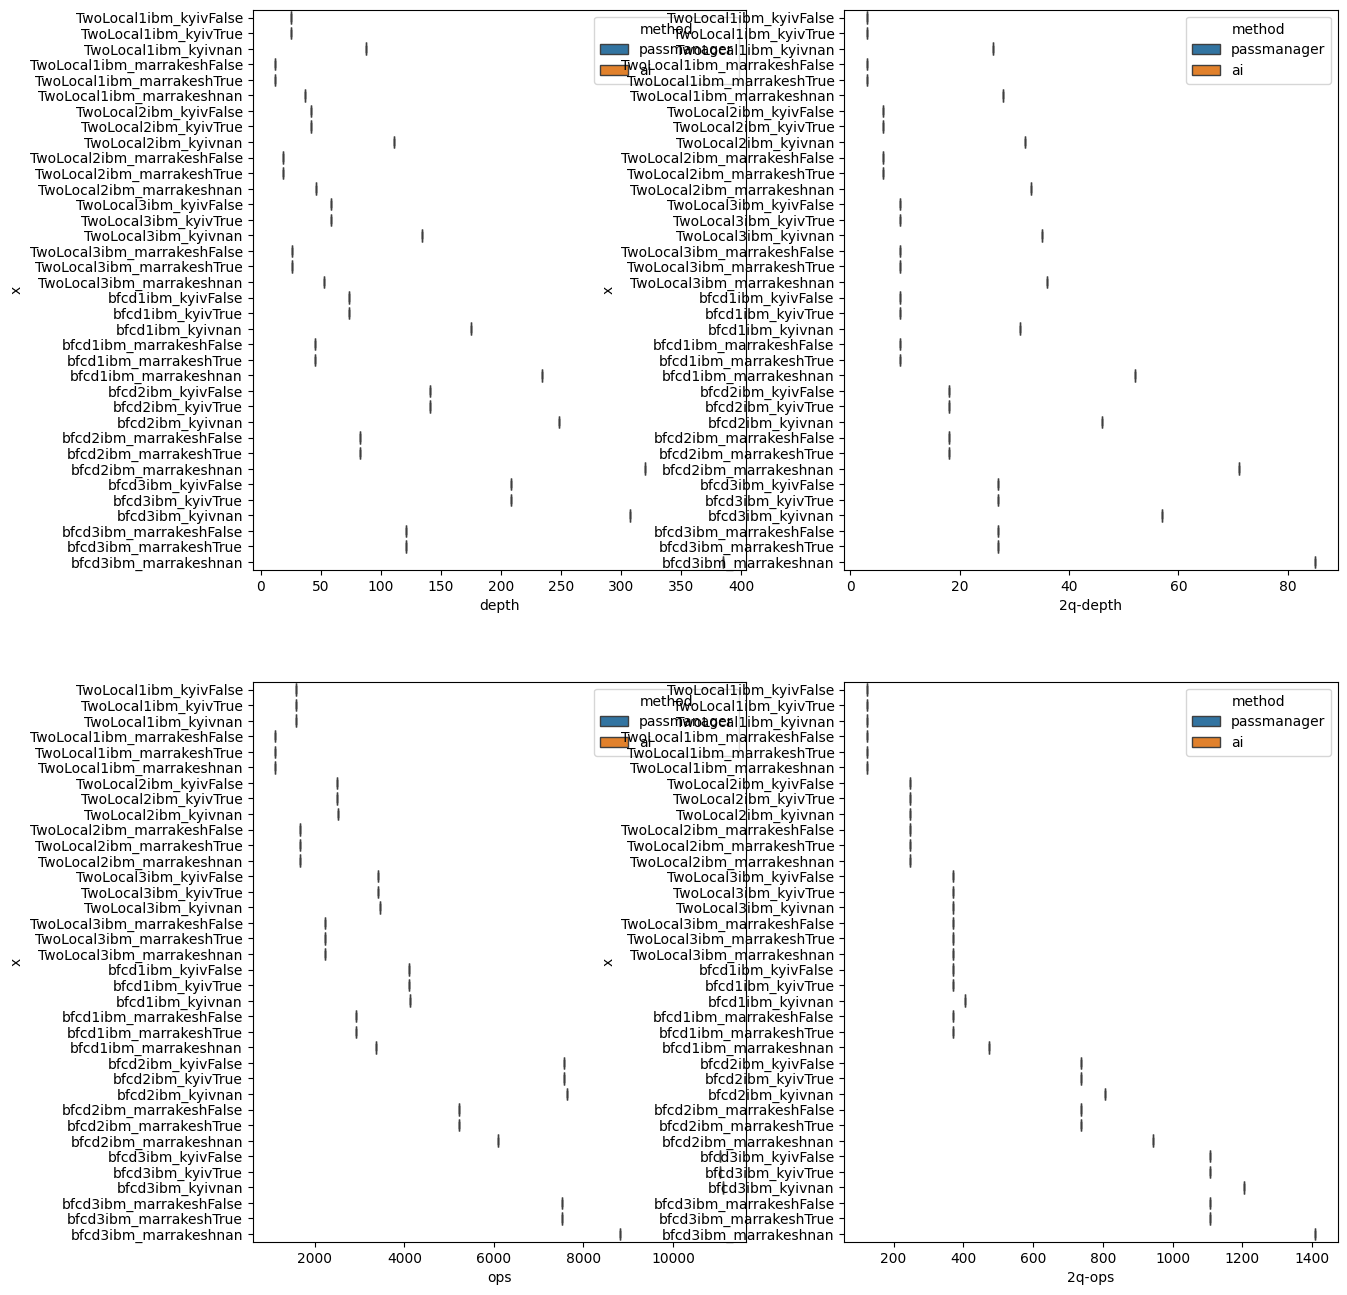

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


df_passmanager['method'] = 'passmanager'
df_ai['method'] = 'ai'

df = pd.concat([df_passmanager, df_ai])
df['x']=df['ansatz'] + df['reps'].apply(str) + df['device'] + df['use_init_layout'].apply(str)
df['ops'] = df.count_ops.apply(lambda x: sum(x.values()))
df['2q-ops'] = df.count_ops.apply(lambda x: sum(v for k,v in x.items() if k in ['cz', 'ecr']))
df.sort_values(['x'], inplace=True)

_, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(14,16))
sns.boxplot(df[['x','depth','method']], y='x', x='depth', hue='method', ax=ax1)
# ax1.set_title('depth')
sns.boxplot(df[['x','2q-depth','method']], y='x', x='2q-depth', hue='method', ax=ax2)
# ax2.set_title('2q-depth')
sns.boxplot(df[['x','ops','method']], y='x', x='ops', hue='method', ax=ax3)
# ax3.set_title('ops')
sns.boxplot(df[['x','2q-ops','method']], y='x', x='2q-ops', hue='method', ax=ax4)
# ax4.set_title('2q-ops')

In [ ]:
from qiskit_ibm_runtime import SamplerV2
from qiskit_aer.backends import AerSimulator
import time
import numpy as np

shots = 1
num_vars =109
aer_options={'method' : 'matrix_product_state', 'n_qubits': num_vars}
backend = AerSimulator(**aer_options)
sampler = SamplerV2(mode=backend)
sampler.options.default_shots = shots

# with open(f'{ROOT}/data/transpilation/color/{num_vars}_pm_ibm_marrakesh_bfcd_2_True_0.qpy', 'br') as f:
with open(f'{ROOT}/data/transpilation/color/{num_vars}_pm_ibm_marrakesh_twolocal_2_True_0.qpy', 'br') as f:
    isa_ansatz = qpy.load(f)[0]

st = time.time()
job = sampler.run([(isa_ansatz, np.random.rand(isa_ansatz.num_parameters))])
result = job.result()
et = time.time()

print(et-st)

In [ ]:
109 qubits bfcd (1rep) -> 15 sec on MPS
109 qubits bfcd (2rep) -> aborted after some hours on MPS
